<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/SolutionTPDetectionDeSentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
---
# Détection de "sentiments" (ex. classique tensorflow)

## Collection de données de critiques de films 
Le tp utilisera l'ensemble de données issues de 
[IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) que vous devez télécharger.

Ce fichier CSV contient 50000 revues de films, considérées comme positives ou négatives.

Ces textes sont composés de mots importants (tokens), d'espaces, de signes de ponctuations et de mots de liaisons.

---
Si vous utilisez Colab, vous devez placer le fichier dans votre Drive Google.

Puis il vous faut monter le répertoire drive pour qu'il soit accessible par Colab.
Exécutez le code suivant,  une clé vous sera demandée. Il vous suffit de suivre le lien, de sélectionner votre profile pour obtenir votre clé que vous copierez dans le champs prévu.

In [ ]:
#bloc à exécuter si vous utilisez colab
from google.colab import drive, files

drive.mount('/content/drive')

---
## Préparation des données


### Chargement et nettoyage des données

Pour traiter des textes, le plus souvent il faut :  
  - identifier les termes (**tokens**) entre espaces,
  - supprimer toute ponctuation,
  - supprimer tous les mots qui ne sont pas uniquement composés de caractères alphabétiques,
  - supprimer tous les mots reconnus en tant que mots vides (stop words) (mots de liaison)
  - supprimer tous les mots dont la longueur est < à x caractères.

### Les bibliothèques
La préparation des données implique de pouvoir accéder au système de fichiers, ainsi qu'à une bibliothèque de traitement du langage naturel (ici nltk) et aux bibliothèques spécialisées dans le traitement de texte : 

In [1]:
##import pour les fichiers et le traitement de données : 
from os import listdir
import pandas as pd
from tqdm import tqdm

##import pour la creation de tokens
import nltk
from nltk.corpus import stopwords

##import pour la gestion de ponctuation
from string import punctuation

##import pour une collection spécifique : counter
from collections import Counter

##import pour les réseaux de neurones : 
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

##import classique pour les tableaux efficaces
import numpy as np


In [2]:
# le code suivant charge l'ensemble des mots non importants (en anglais)
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
print(stop_words)

{"won't", 'mustn', 'you', 'y', 'its', 'of', 'own', 'just', 'his', 'if', 'to', 'him', 'won', 'but', 'wouldn', 'theirs', 'was', 'both', 'my', "mightn't", 'too', 'all', 'been', 'when', "weren't", 'where', 'or', "that'll", 'd', "aren't", 'against', 'very', 'during', 'will', 'yourselves', 'further', 'itself', 'than', 'at', 'again', 'so', 'over', 'below', 'she', 'can', 'as', 'we', 'out', 'no', 'ain', 'the', 'up', "couldn't", 'does', 'll', 'it', 'be', 'most', 'off', 'had', 'were', 'there', "shan't", 'them', 'down', 'while', 'doesn', "you'll", 'being', 'how', 'ourselves', 'ours', 'now', "hadn't", 'their', 'did', 'am', 'are', 'because', 'between', 'don', 'that', "hasn't", "you'd", "you're", 'hasn', 'here', 'your', 'has', 'is', 'into', 'this', 'having', 'before', 'in', "haven't", 'needn', 'from', 'herself', 'have', 'haven', 'after', 'weren', 'under', 's', 'hers', 'whom', 'only', "isn't", "didn't", 'mightn', 'yourself', 'with', 'himself', "she's", 'her', 'doing', 'on', "don't", 've', 'shan', 'the

[nltk_data] Downloading package stopwords to C:\Users\emmanuel
[nltk_data]     adam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Fonctions de lectures et d'"épurage" de fichier texte

Les critiques de films sont dans la colonne 'review' du fichier CSV.

Il faut pour chaque review récupérer les mots importants (d'une longueur suffisante, sans ponctuation, sans 'stopword' (a, the, ...).

In [3]:
# get the text at the line num_line of the column column and return the text expured (without stopwords, words < 2 letters, ...) 
def clean_doc(doc:str)->list:
    """retourne la liste de mots clés inclus dans le texte doc 
    qui ne font pas parti des stop_words"""
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans(' ', ' ', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    return tokens
 

In [3]:
#quelques types, optionnels, juste pour un beau code
Series = pd.core.series.Series
DataFrame = pd.core.frame.DataFrame

### Tests de la récupération de mots clés d'un fichier

In [5]:
#ex de repertoire sous colab
#rep = '/content/drive/My Drive/txt_sentoken'
#ex de repertoire sous windows
rep:str = "C:/Users/MOI/Downloads/"
#ex de repertoire sous linux, mac
#rep:str = "/users/MOI/Downloads/"
# mots clés d'un fichier négatif
filename:str = "IMDB Dataset.csv"
datas:DataFrame = pd.read_csv(rep+filename)
#recuperer la colonne des review
reviews:Series = datas['review']

In [6]:
tokens:list = clean_doc(reviews[0])
print('les 10 premiers mots cles de ', reviews[0])
print(tokens[:10])

les 10 premiers mots cles de  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal

### Construire le vocabulaire global

In [7]:
def add_doc_to_vocab(review:str, vocab:Counter):
    """cumule dans la liste vocab les mots de la review 
    (1 seule occurrence par mot dans vocab)"""
    # clean doc
    tokens = clean_doc(review)
    # update counts
    vocab.update(tokens)

def build_voc(serie:Series, vocab:Counter):
    """ajoute au dictionnaire vocab les mots cles de 90% de la serie de données"""
    i=0
    nb = int(serie.size)
    # walk through all files in the folder
    for i in tqdm(range(nb)):
        # add doc to vocab
        add_doc_to_vocab(serie[i], vocab)


In [8]:

    
# creer un vocabulaire (liste de mots clés associés à leurs occurrences)
vocab:Counter = Counter()
build_voc(reviews, vocab)
# afficher le nb de mots cles trouves
print("nb de mots cles trouves dans les repertoires : ", len(vocab))
print("les 10 premiers mots cles du vocabulaire \
(et leur nb d\'apparition dans les exemples)  : \n", end='')
i:int=0
for (mot,count) in vocab.items(): 
    print(mot,':',count,end=", ")
    i = i+1
    if i>10:break
# afficher les 10 mots cles les plus utilises
print("\nles 10 mots cles les plus utilises : ", vocab.most_common(10))


  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:06<00:00, 7991.77it/s]

nb de mots cles trouves dans les repertoires :  174400
les 10 premiers mots cles du vocabulaire (et leur nb d'apparition dans les exemples)  : 
one : 51024, reviewers : 502, mentioned : 1029, watching : 8991, episode : 3054, youll : 2628, hooked : 274, right : 6225, exactly : 1955, happened : 1992, mebr : 451, 
les 10 mots cles les plus utilises :  [('movie', 83510), ('film', 74453), ('one', 51024), ('like', 38989), ('good', 28569), ('even', 24572), ('would', 24024), ('time', 23257), ('really', 22948), ('see', 22534)]


In [9]:
# on peut si on veut augmenter la liste des stop words
# one, movie, film ne nous semblent pas pertinent pour l'analyse des sentiments
stop_words.add('one')
stop_words.add('movie')
stop_words.add('film')

In [10]:
#verification en recréant un vocabulaire (liste de mots clés associés à leurs occurrences)
vocab:Counter = Counter()
build_voc(reviews, vocab)
# afficher le nb de mots cles trouves
print("nb de mots cles trouves dans les repertoires : ", len(vocab))
print("les 10 premiers mots cles du vocabulaire \
(et leur nb d\'apparition dans les exemples)  : \n", end='')
i:int=0
for (mot,count) in vocab.items(): 
    print(mot,':',count,end=", ")
    i = i+1
    if i>10:break
# afficher les 10 mots cles les plus utilises
print("\nles 10 mots cles les plus utilises : ", vocab.most_common(10))

100%|██████████| 50000/50000 [00:06<00:00, 8093.99it/s]

nb de mots cles trouves dans les repertoires :  174397
les 10 premiers mots cles du vocabulaire (et leur nb d'apparition dans les exemples)  : 
reviewers : 502, mentioned : 1029, watching : 8991, episode : 3054, youll : 2628, hooked : 274, right : 6225, exactly : 1955, happened : 1992, mebr : 451, first : 17154, 
les 10 mots cles les plus utilises :  [('like', 38989), ('good', 28569), ('even', 24572), ('would', 24024), ('time', 23257), ('really', 22948), ('see', 22534), ('story', 22090), ('much', 18947), ('well', 18791)]


### limiter la taille du vocabulaire
Chaque review sera codée par un vecteur indiquant si le mot du vocabulaire est contenu en elle.
La taille du vecteur est donc la taille du vocabulaire.
Et donc, le nombre de neurones dans la couche d'entrée sera aussi élevé.
Il est important de trouver un bon équilibre entre un vocabulaire précis, mais concis.

In [11]:
# ne garder que les mots clés apparaissant au moins x fois
min_occurrence:int = 50
tokens:list = [token for (token,count) in vocab.items() if count >= min_occurrence]
print('en otant les mots utilise moins de ', min_occurrence, ' fois,', 
      ' nb de mots cles = ',len(tokens))

en otant les mots utilise moins de  50  fois,  nb de mots cles =  10944


In [12]:
def save_list(lines:list, filename:str):
    """sauve les mots de la liste de commentaires lines dans le fichier filename"""
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

# save tokens to a vocabulary file
save_list(tokens, rep+'vocab.txt')

In [14]:
def load_doc(filename:str)->str:
    """retourne le texte inclu dans le fichier filename"""
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

---
## Représentation en sac de mots

### Convertir les fichiers en listes de mots-clés appartenant au vocabulaire 


In [15]:
def vocab_in_doc(texte:str, vocab:list)->list:
    """retourne la liste des mots cles du texte qui appartenant au vocabulaire vocab"""
    # clean doc
    tokens = clean_doc(texte)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    return ' '.join(tokens)

In [16]:
def process_docs(serie:list, vocab:list)->list:
    """retourne une listes des mots cles des textes contenu dans la serie de texte"""
    lines = list()

    nb = int(serie.size*0.9)
    # walk through all files in the folder
    for i in tqdm(range(serie.size)):
        line = vocab_in_doc(serie[i], vocab)
        lines.append(line)
    return lines

In [17]:
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(rep+vocab_filename)
vocab = vocab.split()
vocab = set(vocab)


In [18]:
# on ne garde qu'un peu de données pour tester les fonctionnalités
# on prendra le tout si la preuve de concept a réussi
reviews = reviews[:10000]

In [19]:
# load training and testing reviews
lines_input:list = process_docs(reviews, vocab)
nb_input:int = len(lines_input)

# summarize what we have
print("nb exemples : ", nb_input)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 8639.63it/s]

nb exemples :  10000



### Convertir les listes de mots en vecteur fréquence d'apparition 
#### Créer le sac de mots de l'ensemble d’entraînement

In [20]:
# create the tokenizer
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(lines_input)
xTrain:np.ndarray = tokenizer.texts_to_matrix(lines_input, mode='freq')

In [21]:
print('Xtrain contient ', xTrain.shape[0], ' exemples de ', xTrain.shape[1], ' valeurs')
print('une valeur = fréquence d\'apparition des mots dans le vocabulaire global.')
print('Ainsi, premier exemple d\'entrainement = \n', xTrain[0])

Xtrain contient  10000  exemples de  10943  valeurs
une valeur = fréquence d'apparition des mots dans le vocabulaire global.
Ainsi, premier exemple d'entrainement = 
 [0. 0. 0. ... 0. 0. 0.]


In [23]:
np.sum(xTrain[0])

0.9999999999999999

On décide que les exemples positifs correspondent à une sortie 0 et que les exemples négatifs correspondent à la sortie 1 :

In [24]:
#ytrain = suite de (0 (classement pour eval positive) puis 1 (classements pour éval négative))
sentiments:Series  = datas['sentiment']
sentiments_output:Series = sentiments[:nb_input]
yOutput:np.ndarray = np.zeros((nb_input, 1))
for i in range(nb_input): 
    if sentiments_output[i]=='positive': yOutput[i]=1

---
## Modèle de réseau pour l'analyse des sentiments
Le réseau contient en couche d'entrée aurant de neurones que de valeurs retenues

In [25]:
#le nb de neurones en entrée (= nb de tokens retenus)
n_words = xTrain.shape[1] 

In [26]:
n_words

10943

In [28]:
#  définir la structure du réseau
model = Sequential()
model.add(Dense(n_words//3, input_shape=(n_words,), activation='elu'))
model.add(Dense(n_words//27, activation='elu'))
model.add(Dense(n_words//243, activation='elu'))
model.add(Dense(1, activation='sigmoid'))
# compile network 
model.compile(loss='hinge', optimizer='adam',  metrics=['accuracy'])


In [29]:
#TODO tester differents nb de tests (epochs)
history = model.fit(xTrain, yOutput, 
                    validation_split = 0.1,                    
#                    validation_data=(xTest, yTest),
                    batch_size=500,
#                    steps_per_epoch=10,
                    epochs=10, 
                    verbose=2)

Epoch 1/10


18/18 - 11s - loss: 0.8781 - accuracy: 0.6946 - val_loss: 0.6847 - val_accuracy: 0.8260 - 11s/epoch - 633ms/step
Epoch 2/10
18/18 - 10s - loss: 0.6097 - accuracy: 0.8980 - val_loss: 0.6200 - val_accuracy: 0.8770 - 10s/epoch - 559ms/step
Epoch 3/10
18/18 - 11s - loss: 0.5576 - accuracy: 0.9421 - val_loss: 0.6192 - val_accuracy: 0.8750 - 11s/epoch - 587ms/step
Epoch 4/10
18/18 - 11s - loss: 0.5460 - accuracy: 0.9540 - val_loss: 0.6176 - val_accuracy: 0.8780 - 11s/epoch - 609ms/step
Epoch 5/10
18/18 - 11s - loss: 0.5388 - accuracy: 0.9606 - val_loss: 0.6182 - val_accuracy: 0.8780 - 11s/epoch - 605ms/step
Epoch 6/10
18/18 - 11s - loss: 0.5343 - accuracy: 0.9641 - val_loss: 0.6218 - val_accuracy: 0.8710 - 11s/epoch - 604ms/step
Epoch 7/10
18/18 - 11s - loss: 0.5325 - accuracy: 0.9658 - val_loss: 0.6211 - val_accuracy: 0.8750 - 11s/epoch - 587ms/step
Epoch 8/10
18/18 - 11s - loss: 0.5310 - accuracy: 0.9674 - val_loss: 0.6265 - val_accuracy: 0.8680 - 11s/epoch - 591ms/step
Epoch 

### Dessiner l'évolution de l'erreur et de la pertinence

In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### Tracer l'erreur d'entrainement / l'erreur de validation
- L'erreur d'entrainement et l'erreur de validation doivent suivre des courbes quasi parallèle.
- L'erreur d'entrainement doit être plus faible que l'erreur de validation
    - si les courbes divergent, si la courbe de validation s'éloigne de la courbe d'entrainement, il y a alors un sur-apprentissage (overfitting) trop adapté aux données d'entrainement, sans doute trop poussé (diminuer les epochs?).
    - s'il y a une erreur d'entrainement trop grande, il y a sous-apprentissage

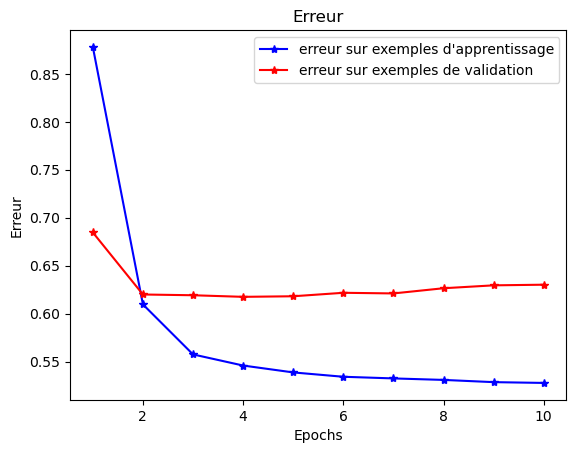

In [31]:
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b-*', label='erreur sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r-*', label='erreur sur exemples de validation')
plt.title('Erreur')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend()

plt.show()

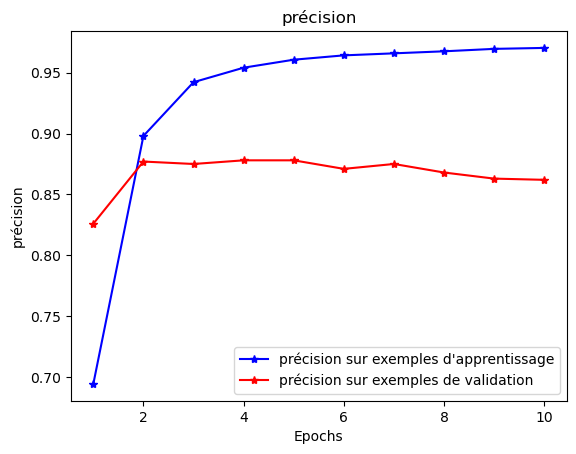

In [32]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b-*', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r-*', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()

### Evaluer le modèle sur l'exemple d'entrainement

---
## Estimation de nouvelles critiques
Il ne reste plus qu'à utiliser le réseau pour faciliter la classification de futures revues ..  

In [33]:
def predict_sentiment(review, vocab, tokenizer, model):
    """classifie le texte dans la variable 'review' en positif (0) ou negatif (1) """
    # clean
    tokens = clean_doc(review)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    # convert to line
    line = ' '.join(tokens)
    # create the bag of words with the words used in the line
    encoded = tokenizer.texts_to_matrix([line], mode='freq')
    # prediction, output is a vector of (1x1) here (output of the neural network is a vector of 1 element)
    output = model.predict(encoded, verbose=0)
    estimation = output[0,0]
    return estimation

In [34]:
# test of a review associated with a note of 10/10
text = 'When I first watched Daniel Craig 15 years ago, I was not ready for the direction they were taking the character. It felt like a good movie, but it felt quite divorced from the Bond I grew up with ... the Bond I knew. But apart from that effort being a Bond begins sort of thing (and this being the other end of that ... line), the franchise bit by bit gave us certain things ... we as viewers yearned for. While keeping it fresh. Bond ... James Bond! That line - one of many that are (in)famous in the long list of Bond movies - gets a new spin here. As is the iconic Bond shooting towards the camera. Now I could name many more things that this film revisits and I probably still would miss some. There are many references here, either visually or via audio. The beginning is quite the introduction ... it is almost funny because it takes its time. And it is funny because the rest sometimes feels rushed. There are many loose ends the movie wants to (neatly?) tie up. Another day, another Bond song, another Bond intro - although quite late in the game. Bond has grown - grown not just over the course of the movie Craig played him, but generally speaking. Society changes and Bond has no issue sitting on on the backseat of a motorbike, while a woman is driving. That is not enough for you to go on a rampage and scream "wokeness". Many known faces return, but many new ones too. Be it the ever excellent if only shortly used Ana de Armas (no pun intended) or our uber villain Rami Malek. Now while I really liked what I saw and while the running time is 2,5 hours ... there are things that can be seen and called flaws. You can question Bonds love to Eva Greens character ... or him still holding onto her, you can question methods used and how convenient certain things happen - or how some stunts would put the Fast and Furious franchise to shame ... but if you did that, you would derive yourself of a lot of fun. Not being aware of the previous entries may not be necessary, but youll have a lot of things to discover and smile at, if you have seen at least some of them. Of course if it is only a few of them, make it the Craig Bonds, so you have the whole ... story. Generally speaking I cant wait to revisit all the movies. No time to watch (them)? Well make time ;) Also to conclude with a fun "fact": the title No time to Die has been used before ... by another movie in 2006. The year Daniel Craig became Bond! Coincidence? Or full circle? All kidding aside, I have not seen that movie (yet), so dont hate on me if it isnt any good. Otherwise, out with the old ... in with the new - whoever that may be and however the franchise is going to reinvent itself ... Ill be there - I hope you will be there too.'#'Having read the book a hundred years ago, it took some time to begin to understand what was going on. If there is a criticism that many share, it is the pacing of the first part of the film. It needed something to set the scene for us, to show us who the strong and the weak were. I m not much for narration (show me, don t tell me), but it may not have been a bad idea. The scenes are magnificent with special effects off the chart. Many desert travel scenes are quite endless. How do you spruce up a desert. I thought the sand worms were a little one dimensional. I know there is another film down the road.'
resultat = predict_sentiment(text, vocab, tokenizer, model)
print('\'',text,'\'\n ------> est considere comme ', 'positif' if resultat>0.5 else 'negatif')
print(resultat)
print("=-=-=-=-=-=-=-=-=-=-=-=")
# test of a review associated with a note of 1/10
text = 'I was so angry after watching that I had to write something. Boring boring boring, the biggest reason for that is scenario 0/10. It is too long, if I hadn\'t go to cinema and bought ticket there is no way I would have patience to watch it until the end. Everything already seen in previous marvel movies, it seems that every new is even worse with lower quality and I didn\'t even have big expectations before the movie. The main reason I decided to watch it is IMDB rate 9/10 which is total fraud and paid advertisement. There is no guarantee if some character is dead that he will remain dead, everyone could resurrect...Go watch anything else than this. My last marvel movie for sure, so angry that I don\'t watch american movies in cinema any more, all the same, low quality in recent time, just to make many fast, without proper scenario...bull..it'
resultat = predict_sentiment(text, vocab, tokenizer, model)
print('\'',text,'\'\n ------> est considere comme ', 'positif' if resultat>0.5 else 'negatif')
print(resultat)

text = 'if you want to skip this review just jump to the IMDb list of awards and nominations, and you re done. If you want the skinny, let me say this is one of the most perfect dramas ever to grace your flat screen. Harrelson, you need to understand, is no slouch. He does crazy better than crazy people. And he usually steals any scene not nailed down. But Matthew McConaughey operates at such a level here -- not to mention the astonishing makeup which makes him appear to be playing his own father -- that he walks off with this production. Mesmerizing. Everyone is pitch perfect, which I believe explains the casting awards. Even Michelle Monaghan, usually known for getting by on her amazing looks, does more acting her than anytime in her career ((Designated IMDb Top Reviewer. Please check out my list 167+ Nearly-Perfect Movies (with the occasional Anime or TV miniseries) you can/should see again and again (1932 to the present))'
resultat = predict_sentiment(text, vocab, tokenizer, model)
print('\'',text,'\'\n ------> est considere comme ', 'positif' if resultat>0.5 else 'negatif')
print(resultat)

text = 'Season 4 epitomizes the downfall of a once-great series, with a storyline that s nothing short of disappointing. While the music attempts to salvage the sinking ship, the characters wander aimlessly like lost souls in a blizzard. Feeble attempts at zombie-style scares fall flat, leaving viewers more frustrated than frightened. It s a shameful display from the producers, who squandered resources by flying in talent from all corners of the globe, only to deliver a narrative that feels as frozen as the characters themselves. Unraveling the mystery of this series  brutak murder would require the keen eye of a true detective.'
resultat = predict_sentiment(text, vocab, tokenizer, model)
print('\'',text,'\'\n ------> est considere comme ', 'positif' if resultat>0.5 else 'negatif')
print(resultat)


' When I first watched Daniel Craig 15 years ago, I was not ready for the direction they were taking the character. It felt like a good movie, but it felt quite divorced from the Bond I grew up with ... the Bond I knew. But apart from that effort being a Bond begins sort of thing (and this being the other end of that ... line), the franchise bit by bit gave us certain things ... we as viewers yearned for. While keeping it fresh. Bond ... James Bond! That line - one of many that are (in)famous in the long list of Bond movies - gets a new spin here. As is the iconic Bond shooting towards the camera. Now I could name many more things that this film revisits and I probably still would miss some. There are many references here, either visually or via audio. The beginning is quite the introduction ... it is almost funny because it takes its time. And it is funny because the rest sometimes feels rushed. There are many loose ends the movie wants to (neatly?) tie up. Another day, another Bond s